Davide Ligabue,   MATR: 0001191187, davide.ligabue@studio.unibo.it  
Leonardo Benini,  MATR: 0001189330, leonardo.benini3@studio.unibo.it

# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

In [26]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Dict, Optional
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [27]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [28]:
# ImageNet mean and std for normalization
IMG_SIZE = (224, 224) # A common size for image classification tasks
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Create Dataset instances
train_dataset = OxfordPetDataset(split="train", transform=train_transform)
val_dataset = OxfordPetDataset(split="val", transform=val_test_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_test_transform)

# Create DataLoader instances
BATCH_SIZE = 128 # You can tune this hyperparameter

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Get number of classes
NUM_CLASSES = train_dataset.get_num_classes()
INPUT_DIM = len(train_dataset[0][0])
print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Number of classes: 37
Training samples: 3669
Validation samples: 1834
Test samples: 1846


In [29]:
# Check for CUDA availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

Using device: cuda


In [30]:
class CustomModel(nn.Module):
    def __init__(self,
                 n_classes: int,
                 input_dim: int,
                 hidden_dim: int,
                 n_hidden_layers: int,
                 use_batchnorm: bool,
                 dropout_p: float,
                 stem_kernel_size: int):
        super().__init__()
        padding = (stem_kernel_size - 1) // 2

        # Stem layer
        stem_layers = [nn.Conv2d(input_dim, hidden_dim, kernel_size=stem_kernel_size, stride=2, padding=padding, bias=not use_batchnorm)]
        if use_batchnorm: stem_layers.append(nn.BatchNorm2d(hidden_dim))
        stem_layers.extend([nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=3, stride=2)])
        self.stem = nn.Sequential(*stem_layers)

        # Convolutional blocks
        conv_blocks = []
        in_channels = hidden_dim
        for _ in range(n_hidden_layers):
            out_channels = in_channels * 2
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=not use_batchnorm)]
            if use_batchnorm: block.append(nn.BatchNorm2d(out_channels))
            block.extend([nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2)])
            conv_blocks.append(nn.Sequential(*block))
            in_channels = out_channels
        self.features = nn.Sequential(*conv_blocks)

        # FC Head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Dropout(p=dropout_p),
            nn.Linear(in_channels, max(in_channels // 2, 1), bias=False),
            nn.ReLU(inplace=True), nn.Dropout(p=dropout_p),
            nn.Linear(max(in_channels // 2, 1), n_classes))

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.classifier(x)
        return x

In [31]:
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                device: torch.device,
                scheduler: Optional[lr_scheduler.LRScheduler] = None) -> Tuple[float, float]:
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None: 
            scheduler.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions.double() / total_samples
    return avg_loss, avg_acc.item()

def evaluate_model(model: nn.Module,
                   dataloader: DataLoader,
                   criterion: nn.Module,
                   device: torch.device) -> Tuple[float, float]:
    model.eval()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions.double() / total_samples
    return avg_loss, avg_acc.item()

def plot_history(history: Dict[str, List[float]]):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [32]:
EPOCHS = 200
HIDDEN_DIM = 64

def run_experiment(config: Dict, model = None):
    print("="*60 + f"\nStart running the model: {config['experiment_name']}\n" + "="*60)
    fix_random(42)

    if model is None: 
        model = CustomModel(input_dim=INPUT_DIM,
                            hidden_dim=HIDDEN_DIM,
                            n_classes=NUM_CLASSES,
                            n_hidden_layers=config['n_layers'],
                            use_batchnorm=config['use_batchnorm'],
                            dropout_p=config['dropout_p'],
                            stem_kernel_size=config['stem_kernel_size']
                            ).to(DEVICE)

    # Setup of Early stopping, LR schedule and weight decay
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.get("lr", 1e-3), weight_decay=config['weight_decay'])
    if config['use_scheduler']:
        warmup_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=5)
        main_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=15)

    # Training Loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    pbar = tqdm(range(EPOCHS), desc=f"Training {config['experiment_name']}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        if config['use_scheduler']:
            if epoch < 5: warmup_scheduler.step()
            else: main_scheduler.step(val_acc)
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{config['experiment_name']}.pt")
            #print(f"Saved new best model, val acc: {val_acc}")
        pbar.set_postfix({"Val Acc": f"{val_acc:.4f}", "Train Acc": f"{train_acc:.4f}"})

    # Final test and save result
    sd = torch.load(f"{config['experiment_name']}.pt")
    model.load_state_dict(sd)
    _, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f"Model '{config['experiment_name']}' completed. Test Accuracy: {test_acc:.4f}\n")

    result = config.copy()
    result.update({'test_accuracy': test_acc, 'best_val_accuracy': best_val_acc, 'history': history})
    return result

### Ablation study


Model's description

The following is the description of how our model was originally thought. A complete ablation study was then made on this model, both on its parameters and on different training strategies (such as the learning rate scheduler or weight decay). After the ablation study the optimal choice of model is presented.

Our custom model is very simple in its structure but it has been able to achive good performance (around 75\% accuracy on the test set). The following is the general structure of the architecture:
- Stem layer as first layer to reduce spatial size: the study explores how changing the kernel's size of this first convolution influences the tuning performance
- A batch norm layer, added for training stability
- Finally a max pooling layer, to further reduce the spatial dimensions, but also for introducing invariance from the input.

Following the first layer a stack of convolutional blocks is added, this choice was made for a better understanding of the model and for an easier implementation (inspired from the AlexNet architecture). Each convolutional block doubles the number of channels in order to increase the complexity of the feature we are looking for (an idea that had already been formulated at the time of LeNet5). 
Each block is made of:
- $3\times 3$ kernels with padding $=1$ and with no stride
- Batch normalization layer
- ReLU
- Max pooling layer

The last part of the architecture, i.e. the classifier, is composed of:
- Adaptive avegering pooling layer, which removes the spatial dimensions without having to know the exact input size
- Flattening
- Dropout layer, to reduce overfitting
- Linear layer to reduce the dimension of the feature vector before the ReLU layer
- ReLU
- Dropout layer
- A final linear layer which classifies the feature vectors in one of the given classes

In [8]:
# Ablation study on model's configuration
ablation_configs = [
    # Baseline
    {"experiment_name": "Baseline (4 Layers, Kernel 11)", "n_layers": 4, "stem_kernel_size": 11, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True},

    # Ablation on the model's components
    {"experiment_name": "No BatchNorm", "n_layers": 4, "stem_kernel_size": 11, "use_batchnorm": False, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True},
    {"experiment_name": "No Dropout", "n_layers": 4, "stem_kernel_size": 11, "use_batchnorm": True, "dropout_p": 0.0, "weight_decay": 1e-3, "use_scheduler": True},
    {"experiment_name": "No Weight Decay", "n_layers": 4, "stem_kernel_size": 11, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 0.0, "use_scheduler": True},
    {"experiment_name": "No LR Scheduler", "n_layers": 4, "stem_kernel_size": 11, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": False},

    # Ablation on the number of Hidden Layers
    {"experiment_name": "2 Hidden Layers", "n_layers": 2, "stem_kernel_size": 11, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True},
    {"experiment_name": "3 Hidden Layers", "n_layers": 3, "stem_kernel_size": 11, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True},
    {"experiment_name": "5 Hidden Layers", "n_layers": 5, "stem_kernel_size": 11, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True},
    
    # Ablation on the dimension of the kernel in the stem layer
    {"experiment_name": "Stem Kernel 7x7", "n_layers": 4, "stem_kernel_size": 7, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True},
    {"experiment_name": "Stem Kernel 3x3", "n_layers": 4, "stem_kernel_size": 5, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True},
]

all_results = [run_experiment(config) for config in ablation_configs]


Start running the model: Baseline (4 Layers, Kernel 11)


Training Baseline (4 Layers, Kernel 11):   0%|          | 0/200 [00:00<?, ?it/s]

Model 'Baseline (4 Layers, Kernel 11)' completed. Test Accuracy: 0.7427

Start running the model: No BatchNorm


Training No BatchNorm:   0%|          | 0/200 [00:00<?, ?it/s]

Model 'No BatchNorm' completed. Test Accuracy: 0.5628

Start running the model: No Dropout


Training No Dropout:   0%|          | 0/200 [00:00<?, ?it/s]

Model 'No Dropout' completed. Test Accuracy: 0.7600

Start running the model: No Weight Decay


Training No Weight Decay:   0%|          | 0/200 [00:00<?, ?it/s]

Model 'No Weight Decay' completed. Test Accuracy: 0.7351

Start running the model: No LR Scheduler


Training No LR Scheduler:   0%|          | 0/200 [00:00<?, ?it/s]

Model 'No LR Scheduler' completed. Test Accuracy: 0.6788

Start running the model: 2 Hidden Layers


Training 2 Hidden Layers:   0%|          | 0/200 [00:00<?, ?it/s]

Model '2 Hidden Layers' completed. Test Accuracy: 0.3662

Start running the model: 3 Hidden Layers


Training 3 Hidden Layers:   0%|          | 0/200 [00:00<?, ?it/s]

Model '3 Hidden Layers' completed. Test Accuracy: 0.6533

Start running the model: 5 Hidden Layers


Training 5 Hidden Layers:   0%|          | 0/200 [00:00<?, ?it/s]

Model '5 Hidden Layers' completed. Test Accuracy: 0.7492

Start running the model: Stem Kernel 7x7


Training Stem Kernel 7x7:   0%|          | 0/200 [00:00<?, ?it/s]

Model 'Stem Kernel 7x7' completed. Test Accuracy: 0.7551

Start running the model: Stem Kernel 3x3


Training Stem Kernel 3x3:   0%|          | 0/200 [00:00<?, ?it/s]

Model 'Stem Kernel 3x3' completed. Test Accuracy: 0.7530



In [9]:
def plot_key_histories(df, experiments_to_plot, title):
    plt.figure(figsize=(14, 8))
    for name in experiments_to_plot:
        row = df[df['experiment_name'] == name]
        if row.empty: continue
        history = row.iloc[0]['history']
        plt.plot(history['val_acc'], label=name, lw=2)

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Epochs', fontsize=12); plt.ylabel('Accuracy', fontsize=12)
    plt.legend(); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0); plt.show()

Ablation study summary:


,test_accuracy,best_val_accuracy,n_layers,stem_kernel_size,dropout_p
experiment_name,,,,,
No Dropout,0.760022,0.722465,4,11,0.0
Stem Kernel 7x7,0.755146,0.723010,4,7,0.5
Stem Kernel 3x3,0.752979,0.742094,4,5,0.5
5 Hidden Layers,0.749187,0.726827,5,11,0.5
"Baseline (4 Layers, Kernel 11)",0.742687,0.710469,4,11,0.5
No Weight Decay,0.735103,0.712650,4,11,0.5
No LR Scheduler,0.678765,0.654308,4,11,0.5
3 Hidden Layers,0.653304,0.630316,3,11,0.5
No BatchNorm,0.562839,0.505453,4,11,0.5


/tmp/ipykernel_57134/948013299.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='test_accuracy', y='experiment_name', data=df_results, palette='viridis', orient='h')


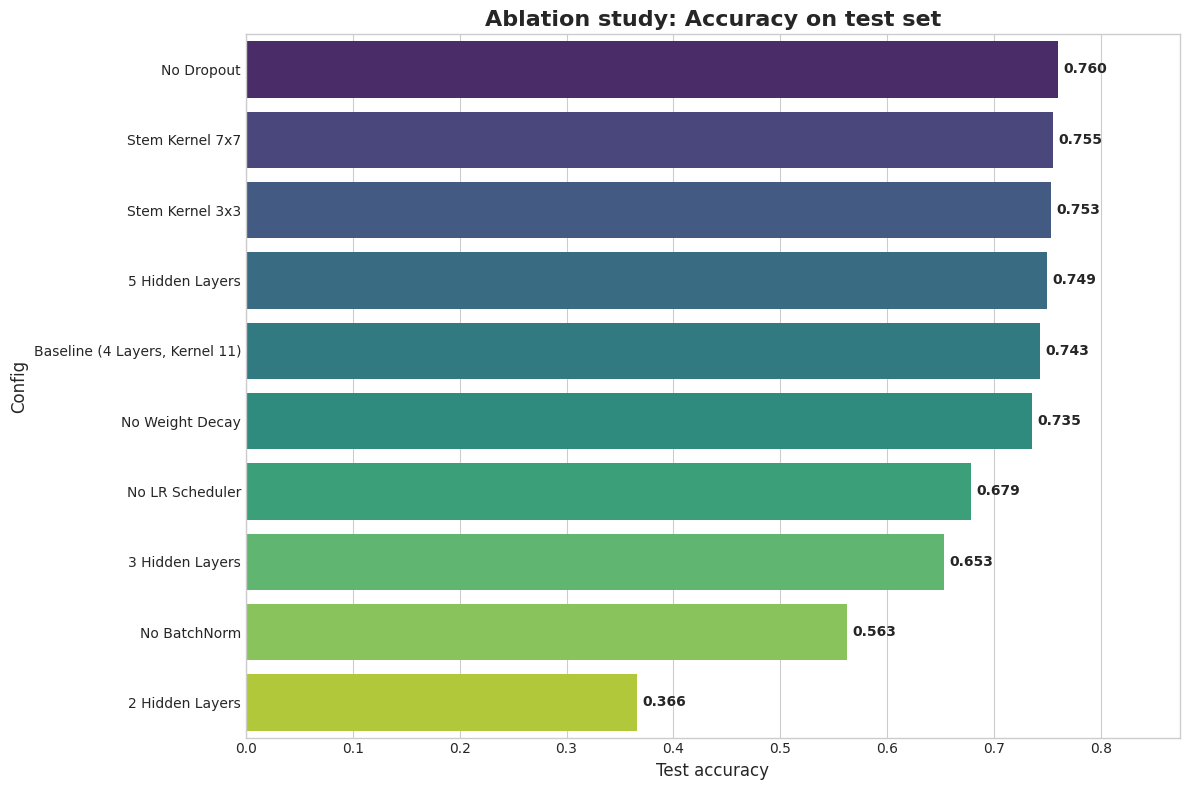

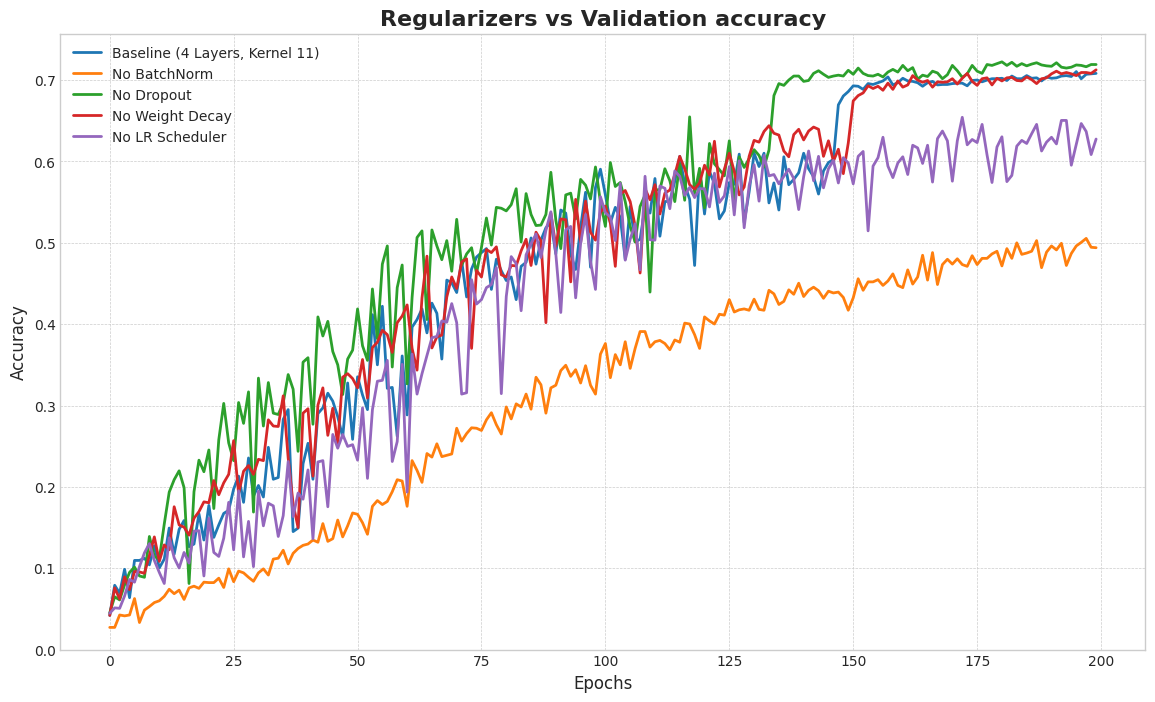

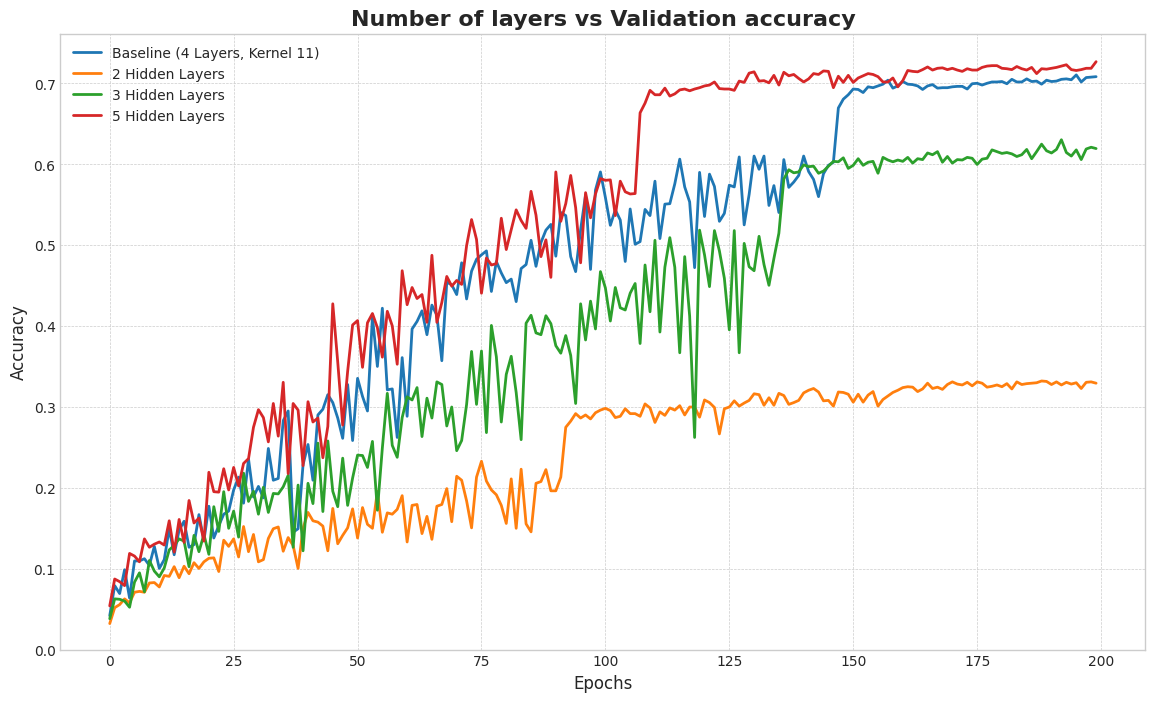

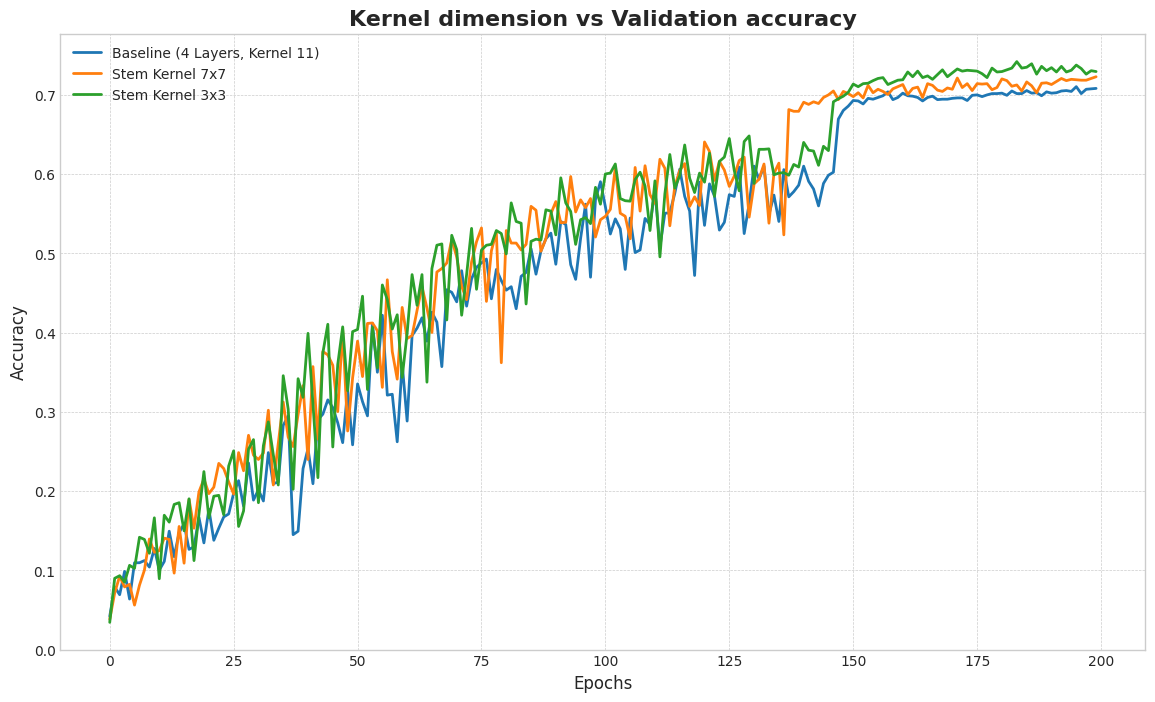

In [10]:
# Create pandas dataframe with results
df_results = pd.DataFrame(all_results).sort_values(by='test_accuracy', ascending=False).reset_index(drop=True)

print("Ablation study summary:")
display(df_results[['experiment_name', 'test_accuracy', 'best_val_accuracy', 'n_layers', 'stem_kernel_size', 'dropout_p']].set_index('experiment_name'))

plt.style.use('seaborn-v0_8-whitegrid')

# 1. Bar plot to compare final accuracy
plt.figure(figsize=(12, 8))
sns.barplot(x='test_accuracy', y='experiment_name', data=df_results, palette='viridis', orient='h')
plt.title("Ablation study: Accuracy on test set", fontsize=16, weight='bold')
plt.xlabel('Test accuracy', fontsize=12)
plt.ylabel('Config', fontsize=12)
plt.xlim(0, max(df_results['test_accuracy']) * 1.15)
for index, value in enumerate(df_results['test_accuracy']):
    plt.text(value + 0.005, index, f'{value:.3f}', va='center', weight='bold')
plt.tight_layout()
plt.show()

# 2. Validation accuracy plot
plot_key_histories(df_results,
                   ['Baseline (4 Layers, Kernel 11)', "No BatchNorm","No Dropout","No Weight Decay","No LR Scheduler"],
                   "Regularizers vs Validation accuracy")

plot_key_histories(df_results,
                   ['Baseline (4 Layers, Kernel 11)', '2 Hidden Layers', '3 Hidden Layers', '5 Hidden Layers'],
                   "Number of layers vs Validation accuracy")

plot_key_histories(df_results,
                   ['Baseline (4 Layers, Kernel 11)', 'Stem Kernel 7x7', 'Stem Kernel 3x3'],
                   "Kernel dimension vs Validation accuracy")

### Final model

As one can see from the display of the results of the ablation study the best choices are:
- using weight decay
- using a learning rate schedule (in our case a combination of an initial warm up phase followed by a reduction on plateau)
- using batch norm and dropout for regularization, to avoid overfitting
- using an initial kernel $7 \times 7$, as it is slightly more performant than the $11 \times 11$ baseline and uses less parameters, therefore less FLOPS and time to train
- using $4$ convolutional blocks, the performance is marginally better than the model with $5$ hidden layers and with less parameters

In [33]:
model = CustomModel(input_dim=INPUT_DIM,
                          hidden_dim=HIDDEN_DIM,
                          n_classes=NUM_CLASSES,
                          n_hidden_layers=4,
                          use_batchnorm=True,
                          dropout_p=0.5,
                          stem_kernel_size=7
                          ).to(DEVICE)

summary(
    model,
    input_size=(3, 224, 224)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 55, 55]               0
            Conv2d-5          [-1, 128, 55, 55]          73,728
       BatchNorm2d-6          [-1, 128, 55, 55]             256
              ReLU-7          [-1, 128, 55, 55]               0
         MaxPool2d-8          [-1, 128, 27, 27]               0
            Conv2d-9          [-1, 256, 27, 27]         294,912
      BatchNorm2d-10          [-1, 256, 27, 27]             512
             ReLU-11          [-1, 256, 27, 27]               0
        MaxPool2d-12          [-1, 256, 13, 13]               0
           Conv2d-13          [-1, 512, 13, 13]       1,179,648
      BatchNorm2d-14          [-1, 512,

Start running the model: Final


Training Final:   0%|          | 0/200 [00:00<?, ?it/s]

Model 'Final' completed. Test Accuracy: 0.7551



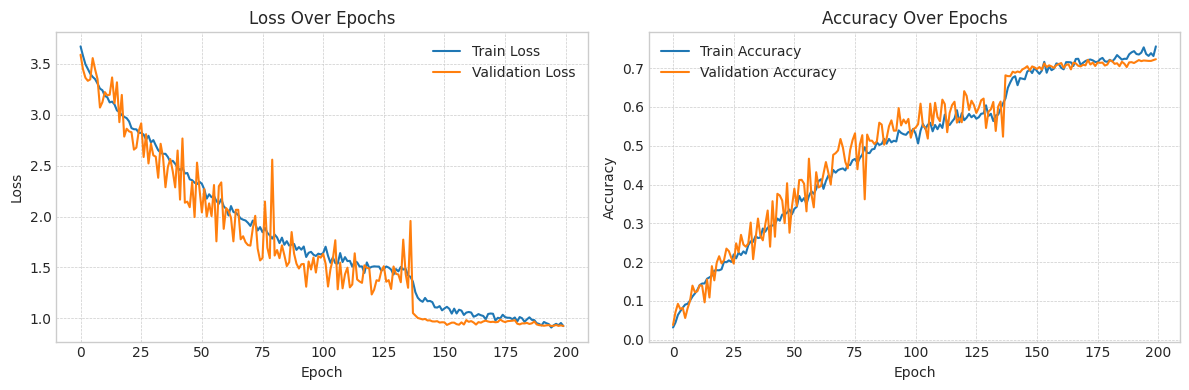

In [34]:
final_config = {"experiment_name": "Final", "n_layers": 4, "stem_kernel_size": 7, "use_batchnorm": True, "dropout_p": 0.5, "weight_decay": 1e-3, "use_scheduler": True}
results = run_experiment(final_config)

plot_history(results["history"])

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

In [35]:
from torchvision.models import resnet18, ResNet18_Weights

In [36]:
def get_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None,
        dropout_prob: Optional[float] = None
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    # Here we override the old classifier
    if dropout_prob is not None:
        model.fc = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(model.fc.in_features, num_classes)
        )
    else:
      model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

def set_requires_grad(layers: list[torch.nn.Module], train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for layer in layers:
      for p in layer.parameters():
          p.requires_grad = train

### 2A

In [37]:
weights = ResNet18_Weights.IMAGENET1K_V1
net_transfer = get_model(NUM_CLASSES, weights, dropout_prob=0.5).to(DEVICE)

set_requires_grad([net_transfer.conv1,  net_transfer.bn1,
                   net_transfer.layer1, net_transfer.layer2,
                   net_transfer.layer3, net_transfer.layer4], True)

summary(
    net_transfer,
    input_size=(3, 224, 224)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Start running the model: Resnet transfer


Training Resnet transfer:   0%|          | 0/50 [00:00<?, ?it/s]

Model 'Resnet transfer' completed. Test Accuracy: 0.8418



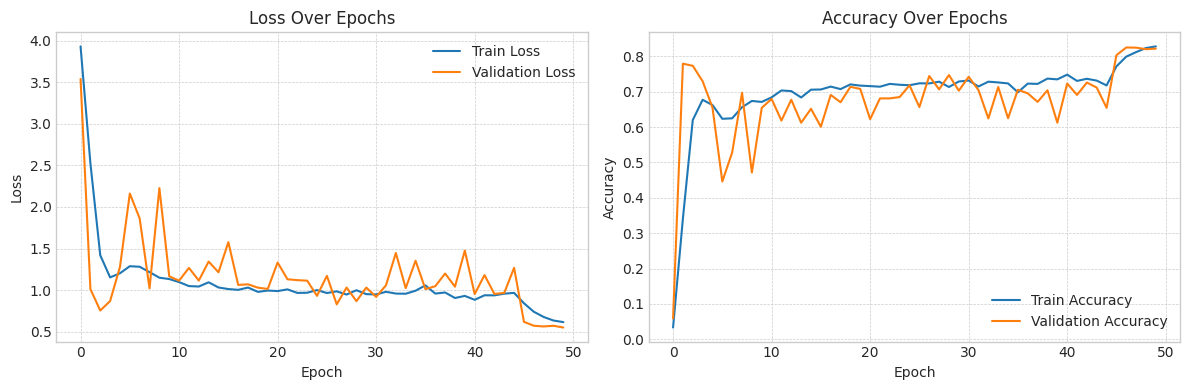

In [38]:
EPOCHS = 50

transfer_config = {"experiment_name": "Resnet transfer", "weight_decay": 1e-3, "use_scheduler": True}
results = run_experiment(transfer_config, net_transfer)

plot_history(results["history"])

Start running the model: Resnet fine-tune


Training Resnet fine-tune:   0%|          | 0/25 [00:00<?, ?it/s]

Model 'Resnet fine-tune' completed. Test Accuracy: 0.8662



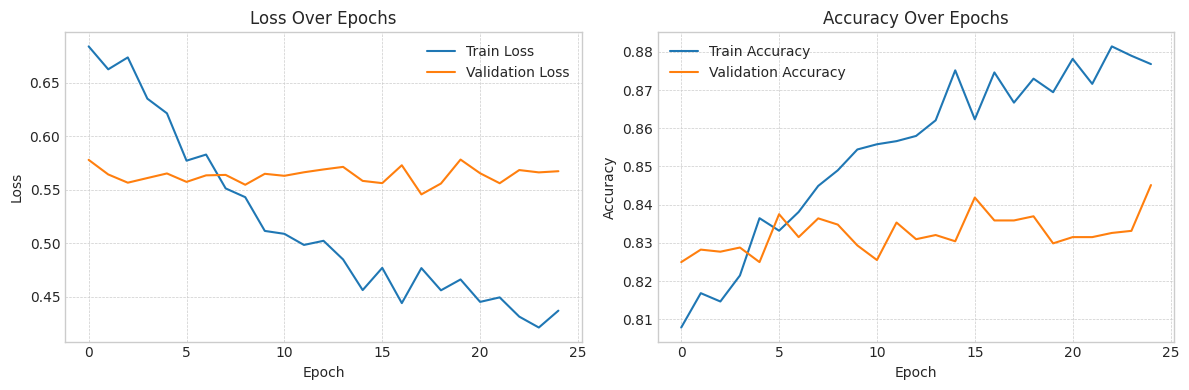

In [39]:
sd = torch.load(f"Resnet transfer.pt")
net_transfer.load_state_dict(sd)

set_requires_grad([net_transfer.conv1,  net_transfer.bn1,
                   net_transfer.layer1, net_transfer.layer2,
                   net_transfer.layer3, net_transfer.layer4], True)

       
EPOCHS = 25

tuning_config = {"experiment_name": "Resnet fine-tune", "lr": 1e-4, "weight_decay": 1e-3, "use_scheduler": True}
results = run_experiment(tuning_config, net_transfer)

plot_history(results["history"])


As we can see, fine-tuning a ResNet18 model pretrained on ImageNet1k is able to achieve much better accuracy than a model trained from scratch, while also requiring much less memory and time to train.  
Even with no hyperparameter changes, simply using the previous ones, the model already achieves an 84.18\% test accuracy after the transfer learning phase, where the classifier is trained while freezing the feature extractor(the convolutional layers).  

Fine-tuning of the entire model does not seem to be very effective, achieving an 86.62\% test accuracy. The validation loss remains constant while the model starts to overfit, this suggest that the pretrained feature extractor is already close to optimal, at least with this particular choice of hyperparameters.

### 2B

To achieve the target accuracy of $\sim 90 \%$ our strategy was based on a two-phase training process (discussed during lectures):

- Feature extraction: initially, all the convolutional layers were frozen and only the final, randomly initialized, classifier was trained for $50$ epoch, using a relatively high learning rate of $10^{-3}$,
- Fine-tuning: The entire network was unfrozen and training was continued for a few epochs ($25$ epochs) with a much lower learning rate of $10^{-5}$ (it's quite important to use a small lr in order to avoid 'forgetting' the valuable pre-trained weights).

Then to optimize the training process and improve the performance of the model two training choices were made that differ from the previous recipe:
- AdamW was chosen as the optimizer. It's often better than the standard Adam optimizer due to the way it decouples weight decay from the learning rate (shown in this paper: 'Decoupled Weight Decay Regularization; Loshchilov & Hutter, 2019'),
- The OneCycleLR was chosen as a scheduler. It's a powerful lr scheduler (as seen also during lectures) which accelerates convergence but also acts as a form of regularization (with a form of initial warm-up phase).

Finally standard data preprocessing for ResNet was implemented, such as normalizing with ImageNet mean and variance and applying simple augmentations like RandomResizedCrop and RandomHorizontalFlip to make training more robust.

In [19]:
mean_image_net = [0.485, 0.456, 0.406]
std_image_net = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_image_net, std_image_net)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean_image_net, std_image_net)
])

# Create Dataset instances
train_dataset = OxfordPetDataset(split="train", transform=train_transform)
val_dataset = OxfordPetDataset(split="val", transform=val_test_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_test_transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # MAYBE ADD PIN MEMORY TRUE
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Get number of classes
num_classes = train_dataset.get_num_classes()
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Number of classes: 37
Training samples: 3669
Validation samples: 1834
Test samples: 1846


In [20]:
def run_experiment(config: Dict, model = None):
    print("="*60 + f"\nStart running the model: {config['experiment_name']}\n" + "="*60)
    fix_random(42)

    # Setup of Early stopping, LR schedule and weight decay
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    num_steps = EPOCHS * len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(optimizer, config["lr"], total_steps=num_steps)

    # Training Loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    pbar = tqdm(range(EPOCHS), desc=f"Training {config['experiment_name']}")
    for _ in pbar:
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE, scheduler)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, DEVICE)
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{config['experiment_name']}.pt")
            #print(f"Saved new best model, val acc: {val_acc}")
        pbar.set_postfix({"Val Acc": f"{val_acc:.4f}", "Train Acc": f"{train_acc:.4f}"})

    # Final test and save result
    sd = torch.load(f"{config['experiment_name']}.pt")
    model.load_state_dict(sd)
    _, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f"Model '{config['experiment_name']}' completed. Test Accuracy: {test_acc:.4f}\n")

    result = config.copy()
    result.update({'test_accuracy': test_acc, 'best_val_accuracy': best_val_acc, 'history': history})
    return result

In [21]:
weights = ResNet18_Weights.IMAGENET1K_V1
net_2b_transfer = get_model(num_classes, weights).to(DEVICE)

set_requires_grad([net_2b_transfer.conv1,  net_2b_transfer.bn1,
                   net_2b_transfer.layer1, net_2b_transfer.layer2,
                   net_2b_transfer.layer3, net_2b_transfer.layer4], False)

summary(net_2b_transfer, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Start running the model: Resnet 2B transfer


Training Resnet 2B transfer:   0%|          | 0/50 [00:00<?, ?it/s]

Model 'Resnet 2B transfer' completed. Test Accuracy: 0.8944



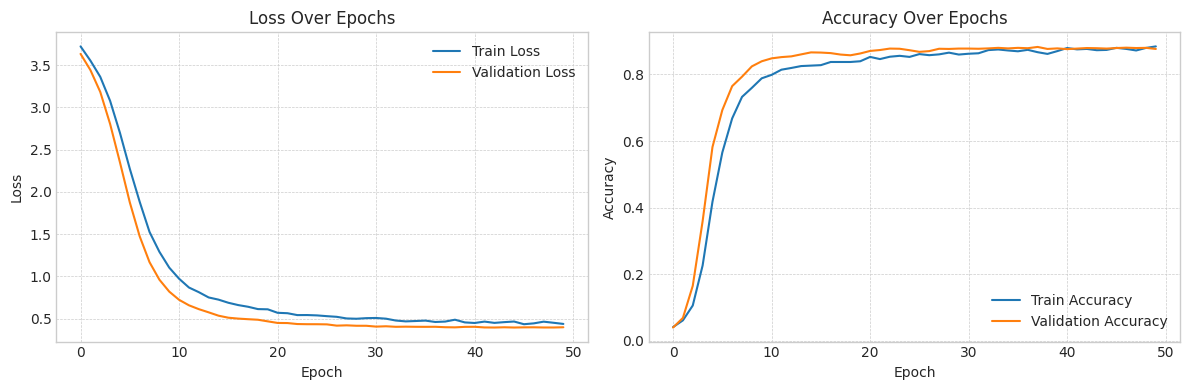

In [22]:
EPOCHS = 50

transfer_2b_config = {"experiment_name": "Resnet 2B transfer", "lr": 1e-3, "weight_decay": 1e-4}
results = run_experiment(transfer_2b_config, net_2b_transfer)

plot_history(results["history"])

Start running the model: Resnet 2B fine-tune


Training Resnet 2B fine-tune:   0%|          | 0/25 [00:00<?, ?it/s]

Model 'Resnet 2B fine-tune' completed. Test Accuracy: 0.8998



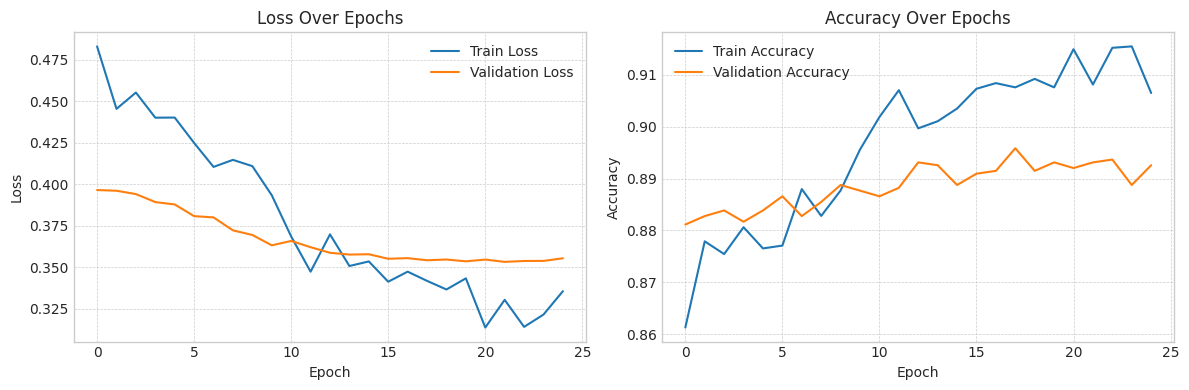

In [23]:
sd = torch.load("Resnet 2B transfer.pt")
net_2b_transfer.load_state_dict(sd)

set_requires_grad([net_2b_transfer.conv1,  net_2b_transfer.bn1,
                   net_2b_transfer.layer1, net_2b_transfer.layer2,
                   net_2b_transfer.layer3, net_2b_transfer.layer4], True)

transfer_2b_config = {"experiment_name": "Resnet 2B fine-tune", "lr": 1e-5, "weight_decay": 1e-4}

EPOCHS = 25
results = run_experiment(transfer_2b_config, net_2b_transfer)
plot_history(results["history"])


As one can see, this model achieves a significant improvement over the previous one. 89.98\% vs 86.62\%.  
The more apparent difference is actually the smoothness of the loss and accuracy history for the transfer learning phase. This is mainly due to the much gentler preprocessing transforms(`RandomResizedCrop` and `RandomHorizontalFlip` vs `RandomAugmentWide`) which in turns makes dropout unnecessary and weight decay less important, since the now unaugmented input data doesn't require such strong regularization anymore.

The fine-tuning phase is also effective. Although the model starts to overfit a bit, validation loss decreased consistently unlike in the previous model.